In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline


import torch.optim as optim
import torchvision as tv

import time

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device
     

'cuda'

In [3]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [4]:

def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [5]:
data_dir = r"C:\\Users\\79169\\Desktop\\simpsons\\simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}\\*\\*.jpg")
data_image_labels = [path.split('\\')[-2] for path in data_image_paths]  

train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels)

In [6]:
print(
    f"Изображений в train: {len(train_files_path)}\n Изображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
 Изображений в val: 6280


In [7]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.7, 0.8, 0.9),
    transforms.RandomAffine(9),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path)

In [8]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [6]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

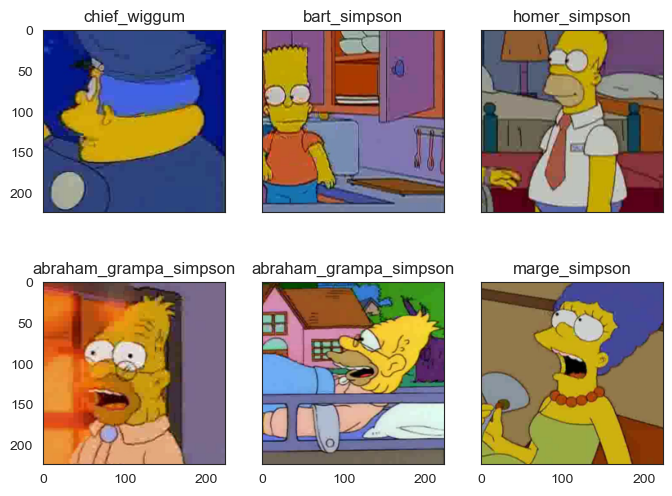

In [25]:

show_images(val_dataset)

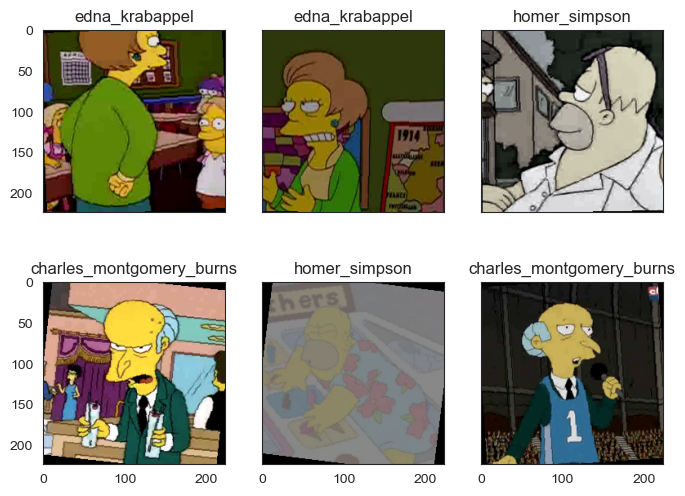

In [26]:
show_images(train_dataset)

In [27]:
model = tv.models.resnet18(weights=False)
model = model.to(device)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [28]:
batch_size = 128

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
    )

Epoch 10 of 10 took 83.131s
  training loss (in-iteration): 	2.159507
  validation loss (in-iteration): 	2.243725
  training accuracy: 			41.40 %
  validation accuracy: 			40.14 %


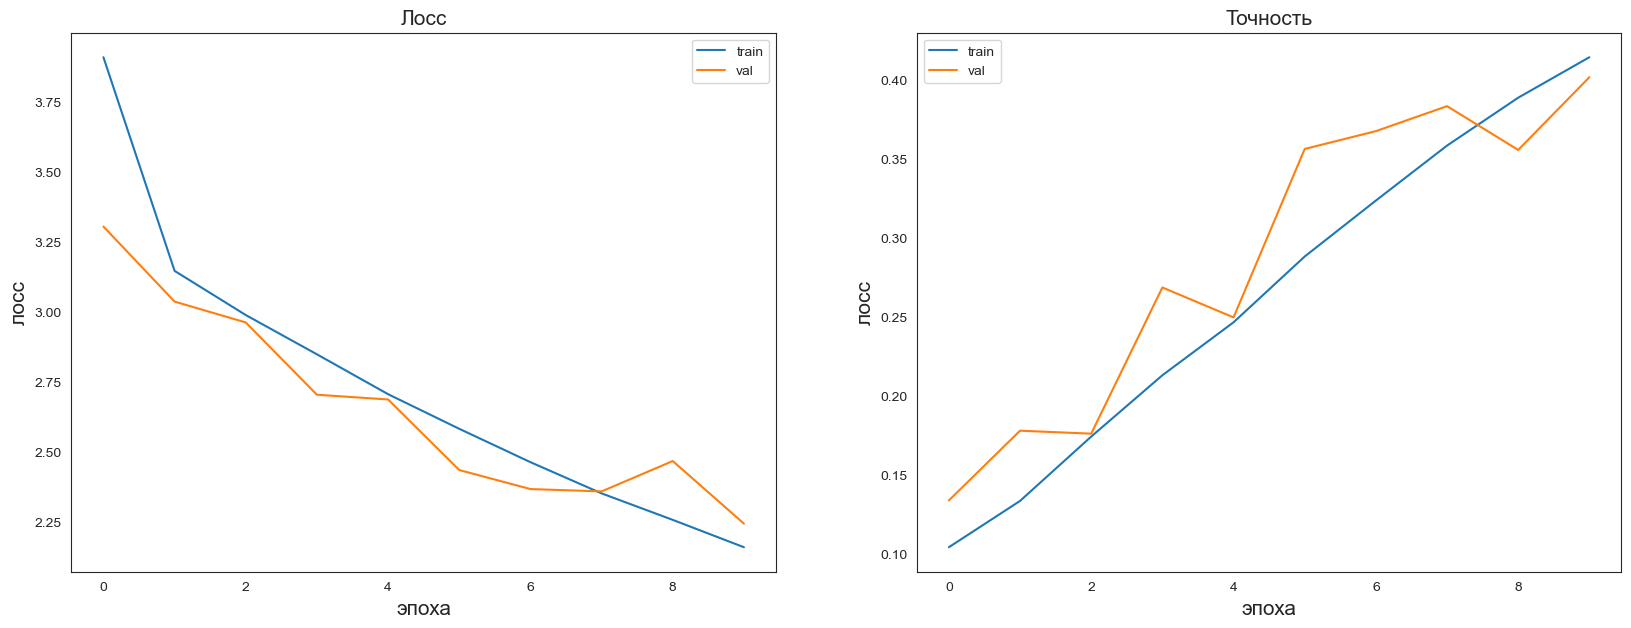

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Вывод: изменив параметры аугментации, добились ЗНАЧИТЕЛЬНОГО ухудшения метрик по сравнению с занятием

# Модель VGG16 для выполнения пунктов 1 и 3 задания

In [56]:
model = tv.models.vgg16(pretrained=True)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1 Вариант: уберем аугментацию и попробуем дообучить предобученную модель с фиксированным lr

In [10]:
input_size = (224, 224)

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor()
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path)

In [58]:

batch_size = 128

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
    )

In [59]:
for param in model.parameters():
    param.requires_grad = False


model.classifier[-1] = nn.Linear(in_features=4096, out_features=42)

In [60]:
model = model.to(device)

In [61]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.6.weight
	 classifier.6.bias


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.01)

Epoch 10 of 10 took 71.041s
  training loss (in-iteration): 	3.733150
  validation loss (in-iteration): 	2.692316
  training accuracy: 			46.63 %
  validation accuracy: 			56.77 %


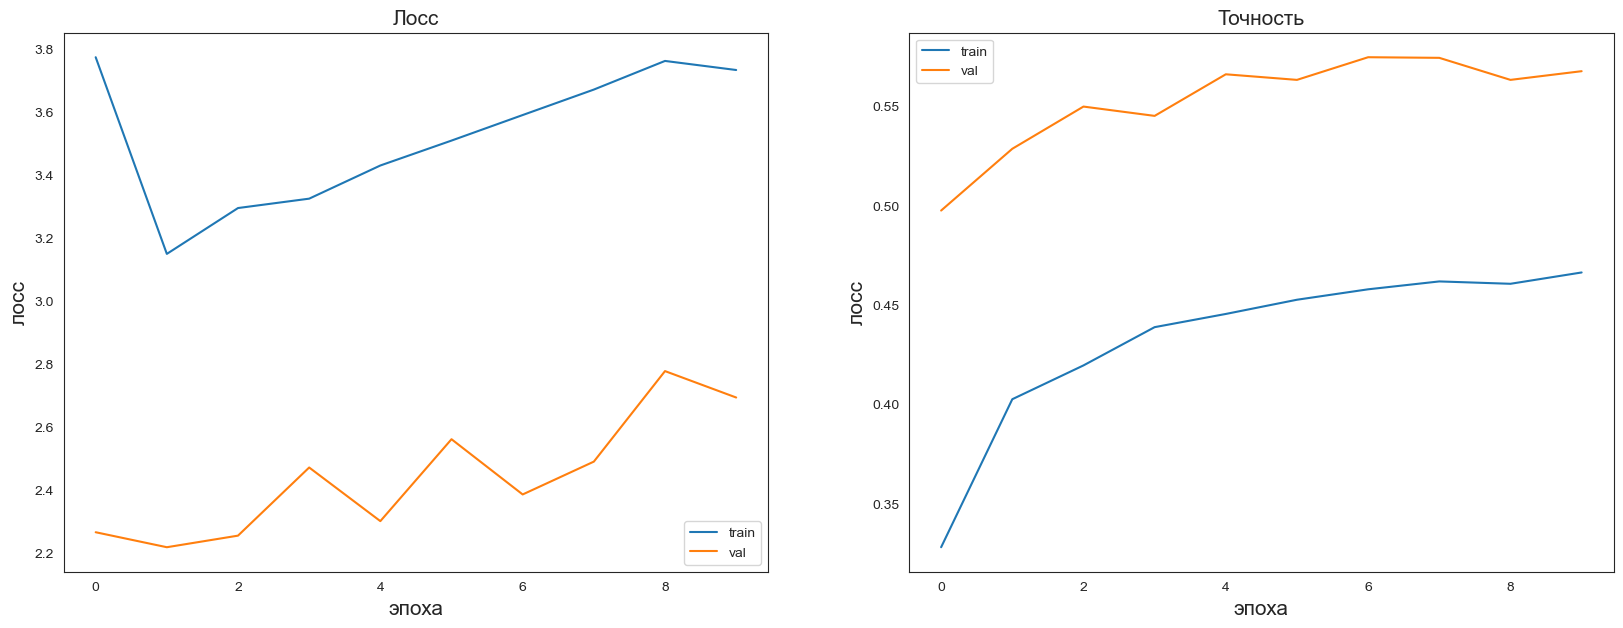

In [55]:
lr, num_epochs = 0.01, 10
clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Вывод: Результат лучше, чем ReSnet с аугментацией, но надо дальше улучшать модель

2 Вариант: тоже самое, но добавим Sheduler

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.01)

In [63]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_batch_gen), epochs=10)

In [28]:
def train_s(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    scheduler,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 10 of 10 took 72.100s
  training loss (in-iteration): 	1.487358
  validation loss (in-iteration): 	1.512380
  training accuracy: 			57.21 %
  validation accuracy: 			61.48 %


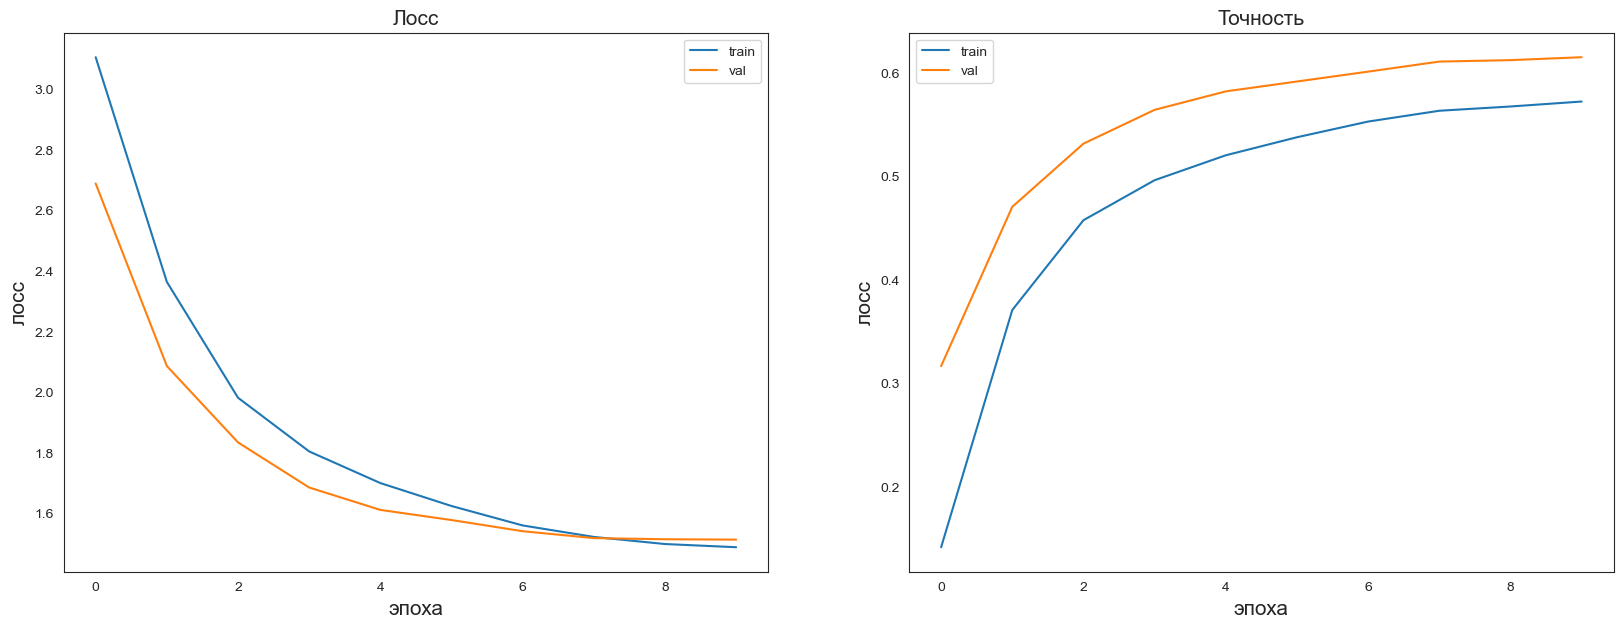

In [66]:

clf_model, history = train_s(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Вывод: С Sheduler получилось лучше, чем без него; теперь будем смотреть не предобученные модели

3 Вариант: обучаем нашу сеть с 0 (не предобученную), без scheduler

In [9]:
model = tv.models.vgg16(pretrained=False)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
input_size = (224, 224)

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor()
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path)

In [11]:
batch_size = 128

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
    )

In [12]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Epoch 10 of 10 took 102.115s
  training loss (in-iteration): 	3.200990
  validation loss (in-iteration): 	3.106198
  training accuracy: 			10.28 %
  validation accuracy: 			12.59 %


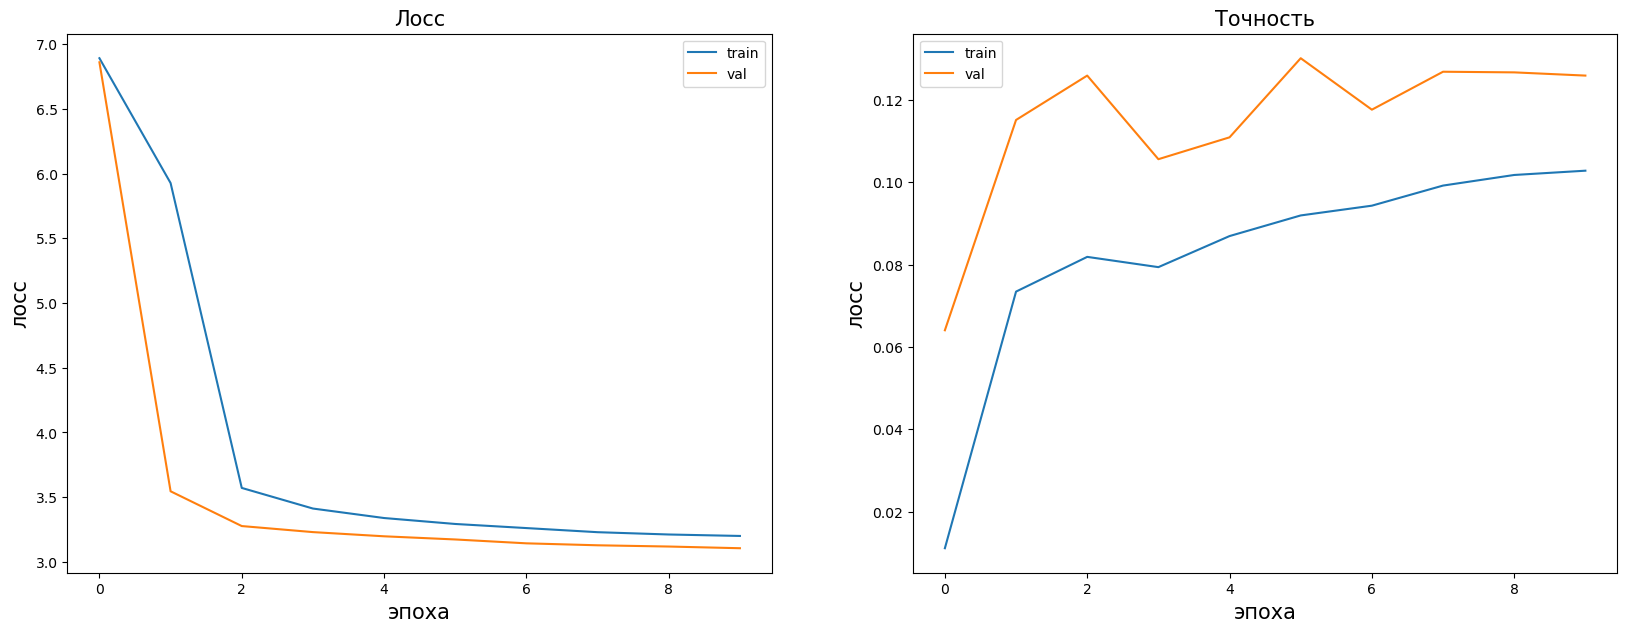

In [13]:
clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10)

Вывод: модель не обучилась, необходимо больше эпох (скорее всего)

4 Вариант: тоже, но с Sheduler

In [33]:
model = tv.models.vgg16(pretrained=False)
model = model.to(device)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(train_batch_gen), epochs=10)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Epoch 10 of 10 took 198.655s
  training loss (in-iteration): 	3.162939
  validation loss (in-iteration): 	3.067888
  training accuracy: 			10.79 %
  validation accuracy: 			15.80 %


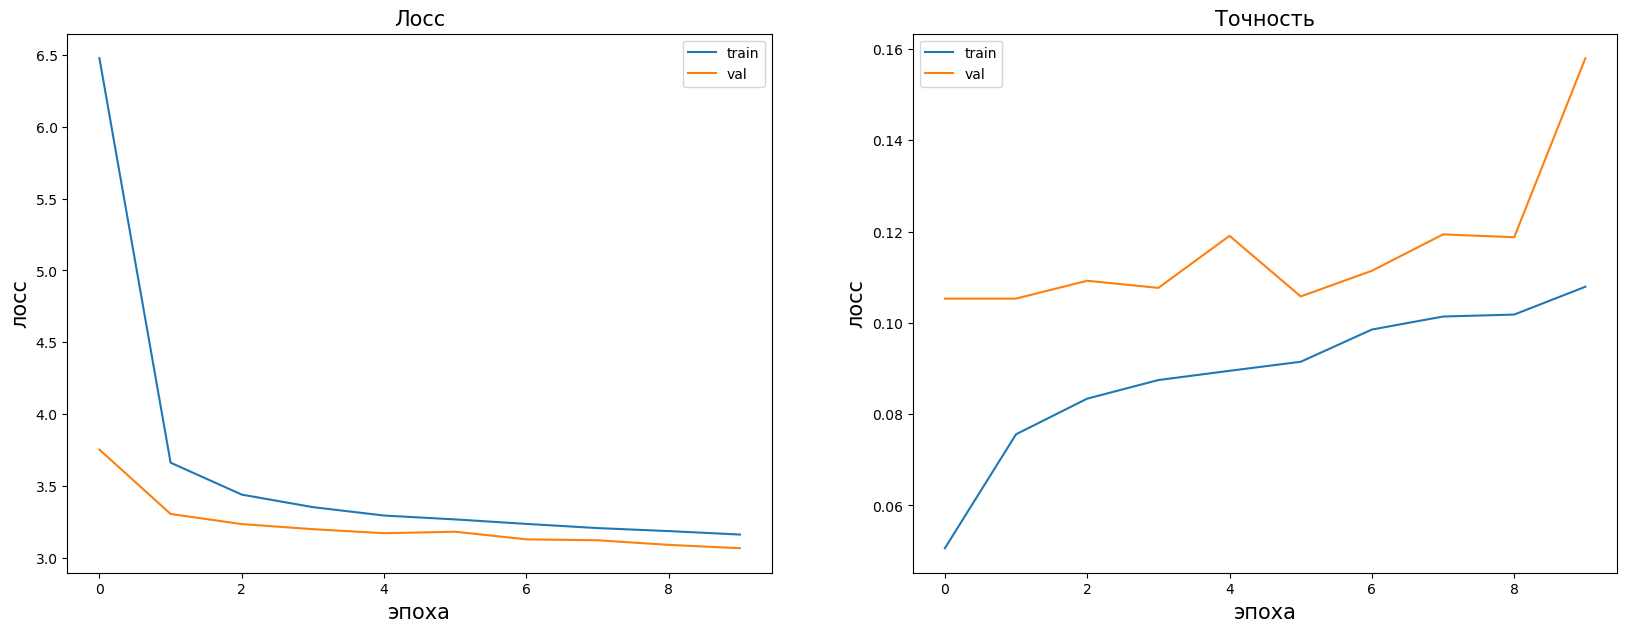

In [35]:
clf_model, history = train_s(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen,
    scheduler, num_epochs=10)

Уже лучше, но нужно больше количество эпох на обучение

In [36]:
torch.cuda.empty_cache()

5 Вариант: fine-tunning модели без Sheduler

In [11]:
vgg16 = tv.models.vgg16(pretrained=True)
vgg16.classifier[-1] = nn.Linear(4096, 1024)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('vgg', vgg16)
fine_tuning_model.add_module('batch_norm_1', nn.BatchNorm1d(1024))
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1024, 512))
fine_tuning_model.add_module('batch_norm_2', nn.BatchNorm1d(512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

In [11]:
batch_size = 128

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
    )

In [14]:
fine_tuning_model = fine_tuning_model.to(device)

Epoch 10 of 10 took 99.070s
  training loss (in-iteration): 	0.414922
  validation loss (in-iteration): 	0.667207
  training accuracy: 			88.29 %
  validation accuracy: 			82.59 %


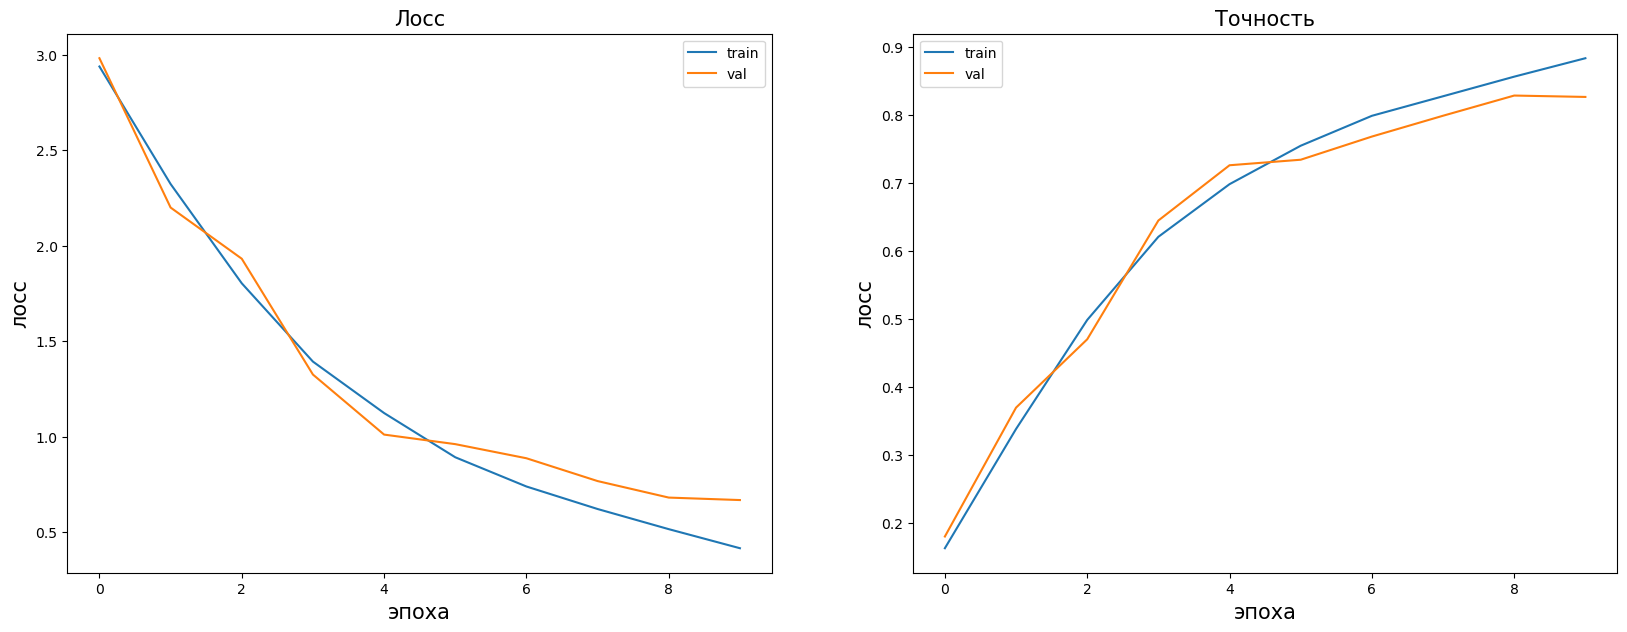

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tuning_model.parameters(), lr=0.001)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Модель показала гораздо более высокие метрики, чем все предыдущие

6 Вариант: тоже, но с Sheduler

In [23]:
torch.cuda.empty_cache()

In [13]:
vgg16 = tv.models.vgg16(pretrained=True)
vgg16.classifier[-1] = nn.Linear(4096, 1024)
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('vgg', vgg16)
fine_tuning_model.add_module('batch_norm_1', nn.BatchNorm1d(1024))
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1024, 512))
fine_tuning_model.add_module('batch_norm_2', nn.BatchNorm1d(512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tuning_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0004, steps_per_epoch=len(train_batch_gen), epochs=10)

In [15]:
fine_tuning_model = fine_tuning_model.to(device)

Epoch 10 of 10 took 121.265s
  training loss (in-iteration): 	0.017760
  validation loss (in-iteration): 	0.123224
  training accuracy: 			99.71 %
  validation accuracy: 			97.28 %


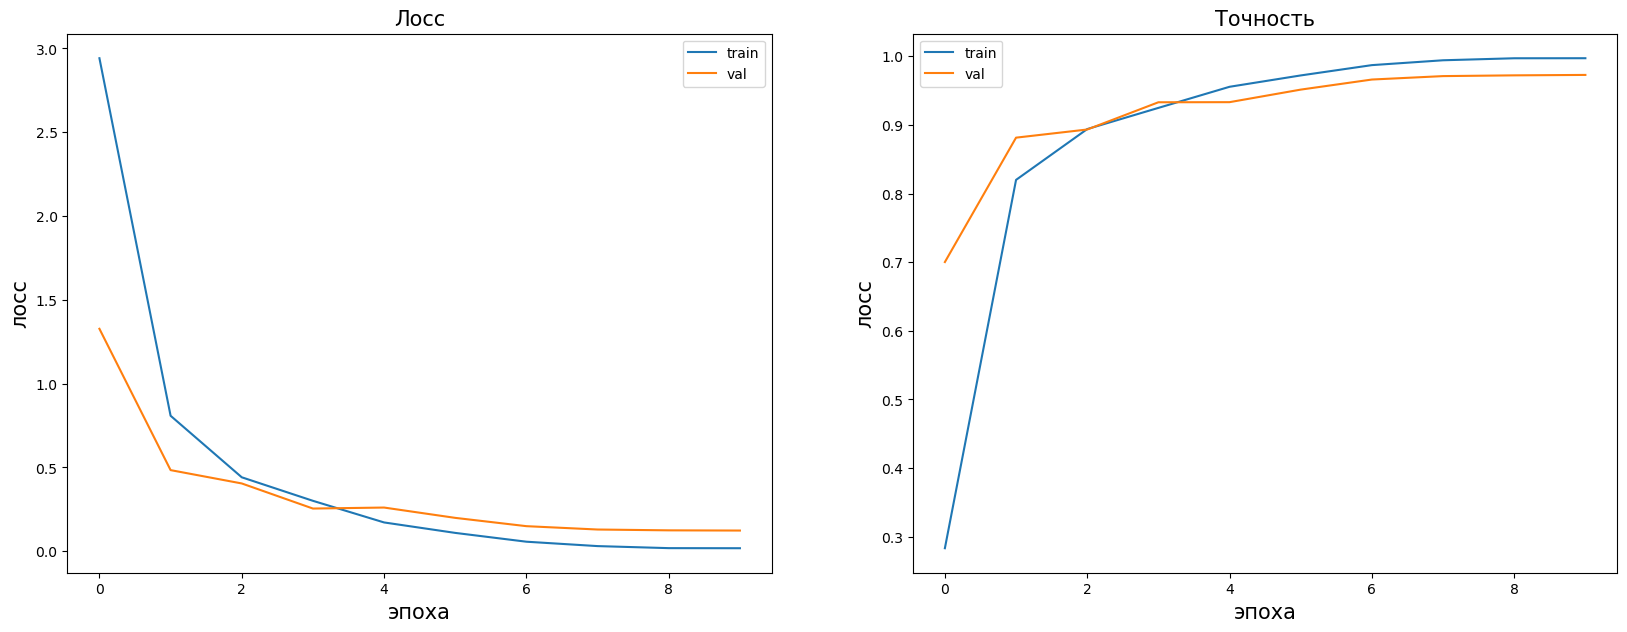

In [16]:
clf_model, history = train_s(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10)

Модель практически идеально обучилась, из чего можно сделать вывод, что при несоответствии датасета (текущего) тому, на котором обучилась модель, лучше всего провести fine-tunning модели